# Introduction to Dynamic Ensembles using metaforecast
## Comparing multiple combination rules

This notebook explores how to combine nixtla's neuralforecast models using several ensemble approaches.
1. Loading M3's monthly dataset
2. Preparing and running cross-validation with 7 neural networks
3. Fitting several combination rules using out-of-sample data from cross-validation
4. Getting forecasts and combining them
5. Evaluating all models

In [1]:
import warnings

warnings.filterwarnings("ignore")

If necessary, install the package using pip:

In [2]:
# !pip install metaforecast

# 1. Data preparation

Let's start by loading the dataset.
This tutorial uses the M3 monthly dataset available on datasetsforecast.

We also set the forecasting horizon and input size (number of lags) to 12.

In [3]:
import pandas as pd

from datasetsforecast.m3 import M3

horizon = 12
n_lags = 12

df, *_ = M3.load('.',group='Monthly')

Split the dataset into training and testing sets:

In [4]:
df_by_unq = df.groupby('unique_id')

train_l, test_l = [], []
for g, df_ in df_by_unq:
    df_ = df_.sort_values('ds')

    train_df_g = df_.head(-horizon)
    test_df_g = df_.tail(horizon)

    train_l.append(train_df_g)
    test_l.append(test_df_g)

train_df = pd.concat(train_l).reset_index(drop=True)
test_df = pd.concat(test_l).reset_index(drop=True)

train_df.query('unique_id=="M1000"').tail()

,unique_id,ds,y
286,M1000,1992-10-31,4563.4
287,M1000,1992-11-30,4551.8
288,M1000,1992-12-31,4577.4
289,M1000,1993-01-31,4592.4
290,M1000,1993-02-28,4632.2


In [5]:
test_df.query('unique_id=="M1000"').head()

,unique_id,ds,y
36,M1000,1993-03-31,4625.6
37,M1000,1993-04-30,4668.2
38,M1000,1993-05-31,4598.0
39,M1000,1993-06-30,4619.4
40,M1000,1993-07-31,4640.4


# 2. Model setup and cross-validation

Let's start by setting up the ensemble members: 7 neural networks based on neuralforecast.

We carry out a cross-validation procedure to get out-of-sample forecasts that will be used to fit the combination rule

In [6]:
from neuralforecast import NeuralForecast
from neuralforecast.models import (NHITS,
                                   LSTM,
                                   GRU,
                                   NBEATS,
                                   MLP,
                                   TiDE)

CONFIG = {
    'input_size': n_lags,
    'h': horizon,
    'accelerator': 'cpu', 
    'max_steps':10,
}

models = [
    NBEATS(**CONFIG, stack_types=3*["identity"]),
    NHITS(**CONFIG),
    MLP( **CONFIG),
    MLP(num_layers=3, **CONFIG),
    LSTM(**CONFIG),
    GRU(**CONFIG),
    TiDE( **CONFIG),
]


nf = NeuralForecast(models=models, freq='M')

2024-10-08 14:56:04,906	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-08 14:56:04,966	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [7]:
%%capture

# should try nf.predict_insample
n_windows = train_df['unique_id'].value_counts().min() - n_lags - horizon
n_windows = int(n_windows // 2)

fcst_cv = nf.cross_validation(df=train_df, n_windows=n_windows, step_size=1)
fcst_cv = fcst_cv.reset_index()
fcst_cv = fcst_cv.groupby(['unique_id', 'cutoff']).head(1).drop(columns='cutoff')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.683     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:

In [8]:
fcst_cv.head()

,unique_id,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,y
0,M1,1992-07-31,4177.104980,4221.372070,6059.322754,5757.848633,4156.243652,5046.999023,-505.670349,5880.0
12,M1,1992-08-31,5850.965820,5870.124023,5154.846680,5500.428711,4174.893066,5065.269043,-302.812683,1680.0
24,M1,1992-09-30,1649.833008,1755.280151,5160.024414,4766.492188,4171.357422,5017.445312,2603.096191,6720.0
36,M1,1992-10-31,6681.443848,6818.136719,5728.097656,5644.381836,4184.693359,5039.948730,636.701538,2040.0
48,M1,1992-11-30,2091.212402,2134.255859,5355.434082,5144.969238,4179.181152,4999.104492,-643.584534,6480.0


# 3. Ensemble combination rule

In this example, we'll fit a polynomially weighted average based on regret minimization:
- loss_type: using the squared loss to evaluate ensemble members
- gradient: using the gradient of the loss
- trim_ratio: keeping only 80% of the best performing models. Others are not used during inference (weight=0)
- weight_by_uid=False: weights are computed for all unique ids jointly. Set to true to do it by unique_id

In [9]:
from metaforecast.ensembles import (MLpol, MLewa, ADE, LossOnTrain, BestOnTrain, EqAverage, Windowing)

In [10]:
TRIM_R = 0.8

combiners = {
    'ADE': ADE(freq='M', meta_lags=list(range(1, 4)), trim_ratio=TRIM_R, trim_by_uid=False),
    'MLpol': MLpol(loss_type='square', gradient=True, trim_ratio=TRIM_R, weight_by_uid=False),
    'MLewa': MLewa(loss_type='square', gradient=True, trim_ratio=TRIM_R, weight_by_uid=False),
    'LossOnTrain': LossOnTrain(trim_ratio=TRIM_R, weight_by_uid=False),
    'BestOnTrain': BestOnTrain(select_by_uid=False),
    'EqAverage': EqAverage(select_by_uid=False, trim_ratio=TRIM_R),
    'Windowing': Windowing(freq='M', trim_ratio=TRIM_R, select_best=False, weight_by_uid=False),
    'BLAST': Windowing(freq='M', trim_ratio=TRIM_R, select_best=True, weight_by_uid=False),
}

In [11]:
for k in combiners:
    print(f'Fitting {k}')
    combiners[k].fit(fcst_cv)

Fitting ADE
Fitting MLpol
Fitting MLewa
Fitting LossOnTrain
Fitting BestOnTrain
Fitting EqAverage
Fitting Windowing
Fitting BLAST


Let's look at the weights of different combiners

<Axes: >

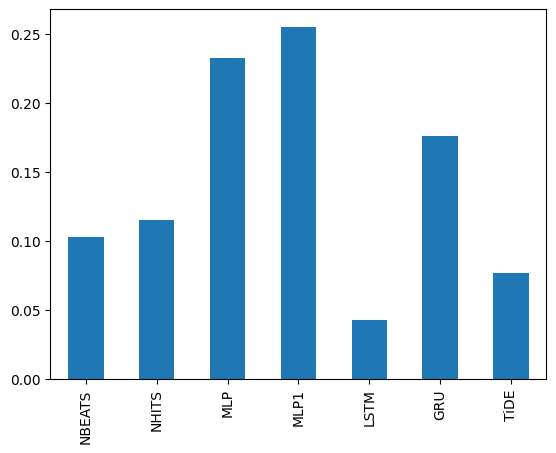

In [12]:
combiners['MLpol'].uid_coefficient['M1000'].plot.bar()

<Axes: >

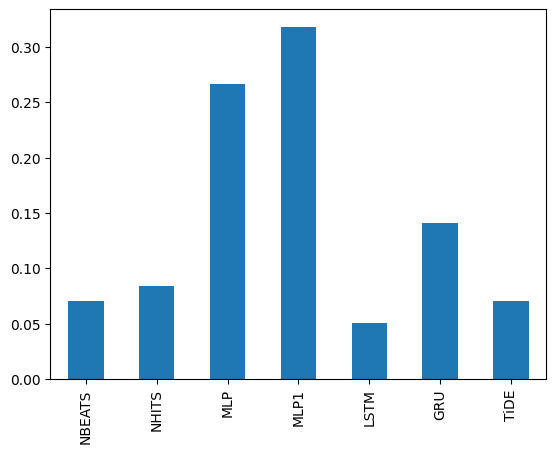

In [13]:
combiners['MLewa'].uid_coefficient['M1000'].plot.bar()

<Axes: >

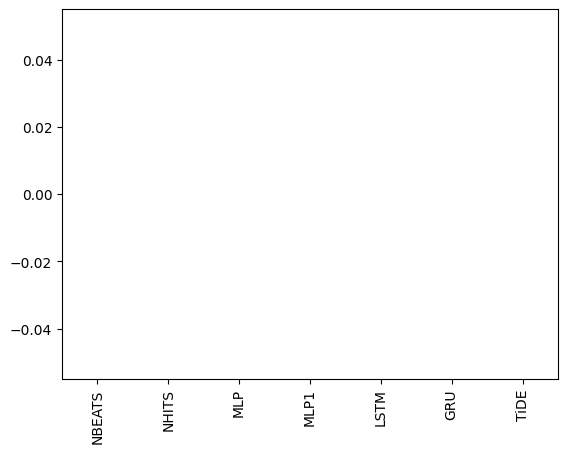

In [14]:
combiners['Windowing'].weights.loc['M1000',:].plot.bar()

Then, we refit the neural networks are get the test forecasts

In [15]:
%%capture

nf.fit(df=train_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.683     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:

In [16]:
%%capture

fcst = nf.predict(step_size=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightni

In [17]:
fcst.query('unique_id=="M1"')

,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
unique_id,,,,,,,,
M1,1994-09-30,2543.799805,2478.665771,3135.228760,3314.506592,3105.154297,2349.724121,1253.825317
M1,1994-10-31,2491.985596,2481.493652,2390.064209,3223.645020,3098.769043,2286.923828,3465.707764
M1,1994-11-30,2517.470703,2507.418945,2399.440918,4006.751465,3093.814209,2362.370605,-1217.538330
M1,1994-12-31,2654.307129,2571.256592,2889.047852,3423.142822,3101.687012,2311.408691,-1540.792969
M1,1995-01-31,2499.323486,2383.421387,2522.879150,3299.654053,3121.572266,2369.968262,771.626953
M1,1995-02-28,2427.915527,2301.941650,2830.046387,3540.731201,3102.312256,2327.601318,1873.627197
M1,1995-03-31,2393.564209,2321.470703,2764.887939,3647.046387,3123.164062,2346.373291,488.055756
M1,1995-04-30,2399.261230,2341.671387,2279.751953,3373.433350,3105.097656,2355.186035,891.664917
M1,1995-05-31,2449.874756,2441.352051,2504.207275,3484.162354,3117.597900,2337.709961,2162.622314


In [18]:
ensemble_fcst = {}
for k in combiners:
    print(k)
    if k == 'ADE':
        # need to make sure unique_id is in columns
        fc = combiners[k].predict(fcst.reset_index(), train=train_df, h=horizon)
    else:
        fc = combiners[k].predict(fcst.reset_index())

    ensemble_fcst[k] = fc

ensemble_fcst_df = pd.DataFrame(ensemble_fcst)

ADE
MLpol
MLewa
LossOnTrain
BestOnTrain
EqAverage
Windowing
BLAST


In [24]:
ensemble_fcst_df

,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,2823.992028,2876.166427,2859.551956,0,0,0,0,0
1,2622.911016,2634.762231,2770.884528,0,0,0,0,0
2,2839.764841,2885.460568,2690.628483,0,0,0,0,0
3,2834.373327,2859.887527,2599.836772,0,0,0,0,0
4,2663.303045,2696.487152,2623.606879,0,0,0,0,0
...,...,...,...,...,...,...,...,...
17131,5334.863941,5398.713898,5186.582400,0,0,0,0,0
17132,5477.737677,5573.925435,5289.384720,0,0,0,0,0
17133,5686.802540,5865.372365,6016.179590,0,0,0,0,0
17134,5408.257808,5491.827750,5578.544939,0,0,0,0,0


In [38]:
ensemble = LossOnTrain(trim_ratio=TRIM_R, weight_by_uid=False)

ensemble.fit(fcst_cv.drop(columns="ds"))




In [39]:
ensemble.n_models

5

In [45]:
top_k = ensemble.insample_scores.apply(ensemble._get_top_k, axis=1)
top_k

M1          [MLP1, LSTM, MLP, GRU, NHITS]
M10      [MLP1, MLP, NHITS, LSTM, NBEATS]
M100      [MLP1, MLP, NBEATS, NHITS, GRU]
M1000     [MLP1, MLP, NBEATS, NHITS, GRU]
M1001     [NBEATS, NHITS, MLP1, MLP, GRU]
                       ...               
M995      [NBEATS, NHITS, MLP1, MLP, GRU]
M996      [NBEATS, NHITS, MLP1, MLP, GRU]
M997     [NBEATS, NHITS, MLP, MLP1, LSTM]
M998      [NBEATS, NHITS, MLP, MLP1, GRU]
M999      [NBEATS, MLP1, MLP, NHITS, GRU]
Length: 1428, dtype: object

In [47]:
for uid, uid_scr in ensemble.insample_scores.iterrows():
    uid

In [49]:
weights = ensemble._weights_from_errors(uid_scr)

weights

NBEATS    0.168457
NHITS     0.168099
MLP       0.168218
MLP1      0.168358
LSTM      0.161508
GRU       0.165361
TiDE      0.000000
dtype: float64

In [51]:
poor_models = [x not in top_k for x in weights.index]
poor_models

[True, True, True, True, True, True, True]

In [30]:
fcst

,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
unique_id,,,,,,,,
M1,1994-09-30,2543.799805,2478.665771,3135.228760,3314.506592,3105.154297,2349.724121,1253.825317
M1,1994-10-31,2491.985596,2481.493652,2390.064209,3223.645020,3098.769043,2286.923828,3465.707764
M1,1994-11-30,2517.470703,2507.418945,2399.440918,4006.751465,3093.814209,2362.370605,-1217.538330
M1,1994-12-31,2654.307129,2571.256592,2889.047852,3423.142822,3101.687012,2311.408691,-1540.792969
M1,1995-01-31,2499.323486,2383.421387,2522.879150,3299.654053,3121.572266,2369.968262,771.626953
...,...,...,...,...,...,...,...,...
M999,1993-10-31,5233.650391,5259.868652,4428.901367,6558.198242,4980.965820,5186.578125,1827.702148
M999,1993-11-30,5311.674316,5314.490234,4911.295410,6690.308105,4959.010742,5152.779785,708.636047
M999,1993-12-31,5222.046875,5326.961426,5954.893555,6784.433594,4930.638184,5138.836426,5355.662109


In [33]:
# ensemble.predict(fcst.reset_index())

ensemble.weights

#ensemble.insample_scores

,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
unique_id,,,,,,,
M1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
M995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M997,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
fcst_all = pd.concat([fcst.reset_index(),ensemble_fcst_df],axis=1)

fcst_all.head()

,unique_id,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,M1,1994-09-30,2543.799805,2478.665771,3135.228760,3314.506592,3105.154297,2349.724121,1253.825317,2823.992028,2876.166427,2859.551956,0,0,0,0,0
1,M1,1994-10-31,2491.985596,2481.493652,2390.064209,3223.645020,3098.769043,2286.923828,3465.707764,2622.911016,2634.762231,2770.884528,0,0,0,0,0
2,M1,1994-11-30,2517.470703,2507.418945,2399.440918,4006.751465,3093.814209,2362.370605,-1217.538330,2839.764841,2885.460568,2690.628483,0,0,0,0,0
3,M1,1994-12-31,2654.307129,2571.256592,2889.047852,3423.142822,3101.687012,2311.408691,-1540.792969,2834.373327,2859.887527,2599.836772,0,0,0,0,0
4,M1,1995-01-31,2499.323486,2383.421387,2522.879150,3299.654053,3121.572266,2369.968262,771.626953,2663.303045,2696.487152,2623.606879,0,0,0,0,0


# 4. Evaluation

Finally, we compare all approaches

In [21]:
test_df = test_df.merge(fcst_all, on=['unique_id','ds'], how="left")

In [22]:
from neuralforecast.losses.numpy import smape
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(test_df, [smape], agg_by=['unique_id'])
evaluation_df

,metric,unique_id,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,smape,M1,0.573117,0.570687,0.632139,0.753699,0.694068,0.544039,1.017743,0.636109,0.645427,0.642796,2.0,2.0,2.0,2.0,2.0
1,smape,M10,0.164020,0.163520,0.241702,0.486605,0.266525,0.197872,1.221932,0.245372,0.280742,0.264919,2.0,2.0,2.0,2.0,2.0
2,smape,M100,0.094209,0.099335,0.132365,0.338048,0.213937,0.114889,1.159019,0.134285,0.154930,0.148130,2.0,2.0,2.0,2.0,2.0
3,smape,M1000,0.010062,0.011725,0.096979,0.234812,0.105149,0.054843,1.236883,0.039547,0.058046,0.035797,2.0,2.0,2.0,2.0,2.0
4,smape,M1001,0.012950,0.019514,0.094136,0.240220,0.152558,0.085466,1.242034,0.038159,0.057653,0.035657,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,smape,M995,0.006537,0.016132,0.089993,0.259439,0.067558,0.010745,1.225985,0.057447,0.081260,0.049890,2.0,2.0,2.0,2.0,2.0
1424,smape,M996,0.016572,0.020123,0.090125,0.251160,0.150761,0.073381,1.240811,0.045667,0.067023,0.039916,2.0,2.0,2.0,2.0,2.0
1425,smape,M997,0.079941,0.079062,0.112319,0.323963,0.105210,0.058785,1.230589,0.124143,0.147096,0.112333,2.0,2.0,2.0,2.0,2.0
1426,smape,M998,0.022725,0.025648,0.100591,0.208072,0.089049,0.041302,1.250119,0.027670,0.042495,0.028643,2.0,2.0,2.0,2.0,2.0


In [23]:
evaluation_df.drop(columns=['metric','unique_id']).mean().sort_values()

MLewa          0.154574
ADE            0.156450
GRU            0.161387
NHITS          0.162831
NBEATS         0.162893
MLpol          0.165705
MLP            0.177414
LSTM           0.218679
MLP1           0.294287
TiDE           1.225373
LossOnTrain    2.000000
BestOnTrain    2.000000
EqAverage      2.000000
Windowing      2.000000
BLAST          2.000000
dtype: float64